In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [2]:
import SimpleITK as sitk


In [3]:
from typing import List, Tuple
import torch
import hydra
import omegaconf
import numpy as np
from omegaconf import DictConfig
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.loggers import Logger

# pyrootutils.setup_root(__file__, indicator=".project-root", pythonpath=True)

import src.utils.default as utils
import matplotlib.pyplot as plt
torch.set_float32_matmul_precision('medium')

In [4]:
from dotenv import load_dotenv

load_dotenv(Path.cwd().parent/'.env')

True

In [5]:
log = utils.get_pylogger(__name__)

EVAL_PATH = '../logs/test_folds_orig_noignore/runs/2023-02-20_14-45-42/.hydra'
CHKPT_PATH = '/mrhome/vladyslavz/git/central-sulcus-analysis/logs/test_folds_orig_noignore/runs/2023-02-20_14-45-42/checkpoints/last.ckpt'

device = 'cuda:0'

In [6]:
cfg = omegaconf.OmegaConf.load(EVAL_PATH + '/config.yaml')

In [7]:
cfg.ckpt_path = CHKPT_PATH

log.info(f"Instantiating datamodule <{cfg.data._target_}>")
datamodule: LightningDataModule = hydra.utils.instantiate(cfg.data)

log.info(f"Instantiating model <{cfg.model._target_}>")
model: LightningModule = hydra.utils.instantiate(cfg.model).to(device)

# # log.info("Instantiating loggers...")
# # logger: List[Logger] = utils.instantiate_loggers(cfg.get("logger"))

# log.info(f"Instantiating trainer <{cfg.trainer._target_}>")
# trainer: Trainer = Trainer(gpus=1, max_epochs=1, logger=False)


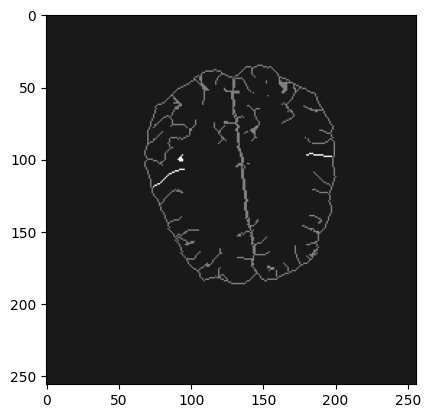

In [8]:
for batch in datamodule.train_dataloader():
    image = batch['image']
    target = batch['target']
# plt.imshow(image[0, 0, 80, :, :], cmap='gray')
# plt.show()
# plt.imshow(target[0, 0, 80, :, :], cmap='gray')
# plt.show()

    plt.imshow(image[0, 0, 80, :, :], cmap='gray', alpha=0.8)
    # plt.show()
    plt.imshow(target[0, 80, :, :], cmap='gray', alpha=0.5)
    plt.show()
    break

In [9]:
# make prediction
with torch.no_grad():
    pred_proba = model(image.to(device))


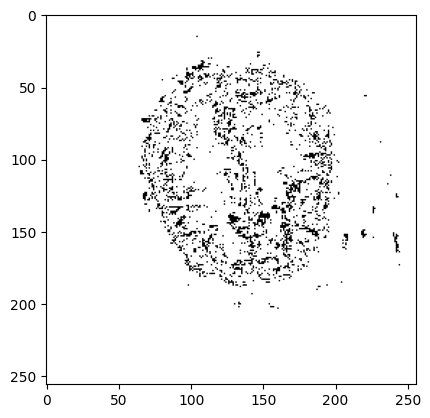

In [10]:
pred = pred_proba.cpu().numpy()
pred = np.argmax((pred[0, :, : :, :]), axis=0)
sliecnum = 85
plt.imshow(pred[sliecnum, :, :], cmap='gray')

## Checking inputs

In [7]:
from src.data.bvisa_dm import CS_Dataset

d1 = CS_Dataset(dataset='bvisa', split='validation', images='folds', target='sulci', dataset_path='/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa')
d2 = CS_Dataset(dataset='bvisa', split='validation', images='skull_stripped', target='sulci', dataset_path='/mrhome/vladyslavz/git/central-sulcus-analysis/data/brainvisa')

eros


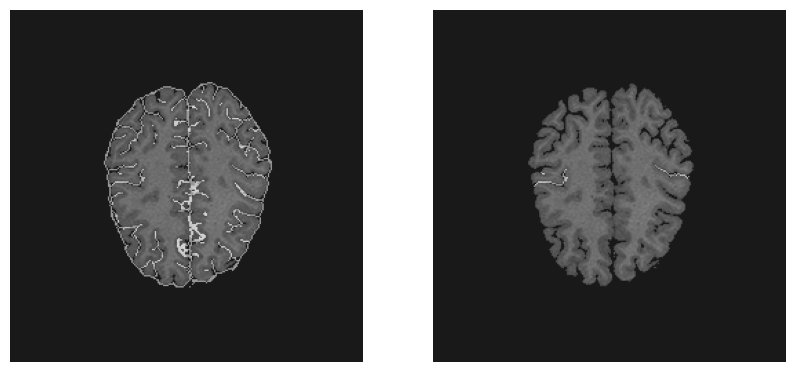

In [8]:
for i in range(len(d1)):
    d1_s = d1[i]
    d2_s = d2[i]
    assert d1_s['caseid'] == d2_s['caseid']
    print(d1_s['caseid'])
    folds = d1_s['image']
    image = d2_s['image']
    gt = d2_s['target']
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image[0, 80, :, :], cmap='gray', alpha=0.8)
    ax[0].imshow(folds[0, 80, :, :], cmap='gray', alpha=0.5)
    ax[0].set_axis_off()
    ax[1].imshow(image[0, 80, :, :], cmap='gray', alpha=0.8)
    ax[1].imshow(gt[80, :, :], cmap='gray', alpha=0.5)
    ax[1].set_axis_off()
    plt.show()
    break

## Checking outputs and loss

In [9]:
from src.models.unet3d.model import UNet3D

In [13]:
model = UNet3D(in_channels=1, out_channels=2, final_sigmoid=False, f_maps=(16, 32, 64, 128))

image_batch = torch.unsqueeze(folds, dim=0)

In [14]:
output = model(image_batch)

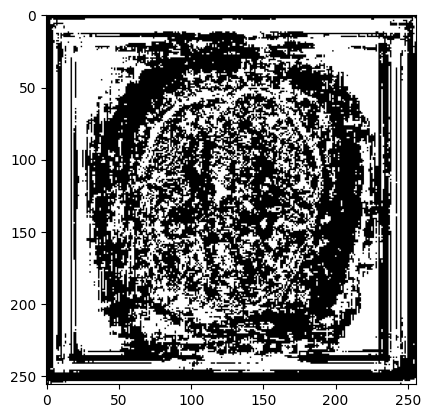

In [15]:
output_bin = torch.argmax(output, dim=1)
plt.imshow(output_bin[0, 80, :, :], cmap='gray')

In [16]:
from torch.nn import CrossEntropyLoss

In [17]:
loss = CrossEntropyLoss()

In [18]:
image_batch.shape

torch.Size([1, 1, 124, 256, 256])

In [ ]:
loss(output, torch.unsqueeze(target, dim=0))

In [19]:
gt.shape

torch.Size([124, 256, 256])

In [20]:
np.unique(gt.numpy())

array([0, 1])

In [25]:
target = torch.unsqueeze(gt, dim=0)

In [22]:
output.shape

torch.Size([1, 2, 124, 256, 256])

In [26]:
target.shape

torch.Size([1, 124, 256, 256])

In [29]:
loss_val = loss(output, target)
print(loss_val)

tensor(0.6577, grad_fn=<NllLoss2DBackward0>)


In [54]:
output.shape

torch.Size([1, 2, 124, 256, 256])

In [55]:
mask.shape

torch.Size([1, 1, 124, 256, 256])

In [64]:
mask = image_batch!=0

y_hat_masked = output[:,:,mask[0][0]]
y_masked = target[mask[0]]

In [65]:
y_hat_masked.shape

torch.Size([1, 2, 143973])

In [66]:
y_masked.shape

torch.Size([143973])

In [71]:
target[:, mask[0][0]].shape

torch.Size([1, 143973])

## Checking Dice Metrics

In [35]:
output_bin = torch.argmax(output, dim=1)

In [33]:
output_bin.shape

torch.Size([2, 124, 256, 256])

In [34]:
output.shape

torch.Size([1, 2, 124, 256, 256])

In [36]:
from torchmetrics import Dice

In [37]:
dice_score = Dice(num_classes=2, ignore_index=0)
dice_score(output, target)

tensor(0.0006)

In [41]:
dice_score = Dice(num_classes=2, ignore_index=0)
dice_score(output_bin, target)

tensor(0.0006)

In [38]:
dice_score = Dice(num_classes=2)
dice_score(output, target)

tensor(0.6505)

In [ ]:
in

In [43]:
output.shape

torch.Size([1, 2, 124, 256, 256])

In [11]:
lsucs = sitk.ReadImage('/mrhome/vladyslavz/Downloads/base62_2019/all/ammon/t1mri/t1/default_analysis/folds/3.3/base2018_manual/segmentation/LSulci_ammon_base2018_manual.nii.gz')

In [13]:
{x:idx-1 for idx, x in enumerate(np.unique(sitk.GetArrayFromImage(lsucs)))}

{0: -1,
 1: 0,
 3: 1,
 4: 2,
 5: 3,
 6: 4,
 7: 5,
 8: 6,
 9: 7,
 10: 8,
 11: 9,
 12: 10,
 13: 11,
 14: 12,
 15: 13,
 16: 14,
 17: 15,
 18: 16,
 19: 17,
 20: 18,
 21: 19,
 22: 20,
 23: 21,
 24: 22,
 25: 23,
 26: 24,
 27: 25,
 28: 26,
 29: 27,
 30: 28,
 31: 29,
 32: 30,
 33: 31,
 34: 32,
 35: 33,
 36: 34,
 37: 35,
 38: 36,
 39: 37,
 40: 38,
 41: 39,
 42: 40,
 43: 41,
 44: 42,
 45: 43,
 46: 44,
 47: 45,
 48: 46,
 49: 47,
 50: 48,
 51: 49,
 52: 50,
 53: 51,
 54: 52,
 55: 53,
 56: 54,
 57: 55,
 58: 56,
 59: 57,
 60: 58,
 61: 59,
 62: 60,
 63: 61,
 64: 62}

In [32]:
non_zeros = np.stack(np.nonzero(image.numpy())).T
x_min, y_min, z_min = non_zeros.min(0)
x_max, y_max, z_max = non_zeros.max(0)
non_zeros_image = image[:, :, x_min:x_max, y_min:y_max, z_min:z_max]

TypeError: cannot unpack non-iterable numpy.int64 object

In [34]:
non_zeros.min(0)

array([ 0,  0,  6, 23, 63])

In [22]:
non_zeros.max(0)[0]

tensor([  0,   0, 120, 188, 206])

In [31]:
np.stack(np.nonzero(image.numpy())).T

array([[  0,   0,   6,  49, 106],
       [  0,   0,   6,  49, 110],
       [  0,   0,   6,  49, 113],
       ...,
       [  0,   0, 120, 142, 149],
       [  0,   0, 120, 142, 150],
       [  0,   0, 120, 143, 148]])